Note: references to code in the repo are not yet set, but should be obvious from the text.
Anyway, a look at the code is always beneficial.

# Overall idea behind COMBINE

Finding bedrock geometry from surface information of glaciers is not straightforward. The ice flow and therefore surface is determined by bed rock and mass balance together with glacier dynamics. This is what a usual forward model does: take bed rock and mass balance and run ice dynamics forward in time to obtain ice thickness/surface height. To go the other way around, we would need a backward model, which is hard to find (unknown in most cases to my knowledge) due to the complexity of ice dynamics.

So what to do? Mass balance may be estimated from climate data with appropriate parametrizations and is assumed to be known.

So a simplified forward model giving a surface $s$ (after time $t$) based on bedrock $b$ would be:
$$s(b, t)$$

So if we now the surface height at time $t_0$ (I referred to it in the model as the moment after spinup) and later on at $t_1$ we can run the forward model from a first - known - state $$s_0 = s(b, t_0)$$ forward to a later state $$s_1 = s(b, t_1)$$ with an estimated bedrock $b$. Assume we know the true surface at $t_1$, $$s_{1, true} = s(b_{true}, t_1)$$. Then we try to estimate $b$ in a way, that $$s(b, t_1) = s(b_{true}, t_1)$$, so the forward run is giving us the observed surface. To find this proper bed estimate, we need a first guess, what it could look like and then iteratively improve our guess. As a measure for the quality of the guess we define a cost function, e.g. $$J(b) = \int_{domain}(s(b, t_1) - s_{true})^2$$, which can be minimized by optimizing $b$.

As easy as this sounds, there is one major caveat: the inversion is ill-posed, meaning, that there are (most probably) multiple possible suitable bedrock estimates. And also the high dimensionality of $b$ together with the complex ice dynamics make it harder for the optimization algorithm. A good first guess close to the actual solution is already a big help.

We can support the optimization further by adding additional knowledge (e.g. bed measurements of known points, but also assumptions of not too big steps in bedrock and knowledge of the actual) and penalizing solutions, that contradict this knowledge. To implement this, regularization terms $J_{reg, i}$ can be added to the cost function and therefore will be considered during optimization:
$$J(b) = \int_{domain}(s(b, t_1) - s_{true})^2 + \alpha_i J_{reg, i}$$

$\alpha_i$ are the regularization parameters (reg_parameters in code), simple factors, that scale the importance of these regularizations. As a general rule, they may be corresponding to the inverse of the variance of a quantity described by a regularization, but I for my part fine tuned them during my thesis. Feel free to play around with them a bit and get some insights in their behaviour/influence. In my opinion, proper choice of regularizations is half the deal.

# Implementation details - why PyTorch?
The dynamics model was originally working on numpy arrays. However, for efficient optimization, a Jacobian of the cost function would be desirable (telling the optimization algorithm, in which way to improve the estimated bed). As it is cumbersome and also not that flexible to changes in code, the derivation is not done by hand. Instead, we exploit the capabilities of PyTorch, originally a deep learning framework. There, Tensors are used instead of numpy arrays. They can more or less be used directly as substitutes, but do have the major advantage of tracing the calculations. This means throughout the forward model run until the cost function calculation, all steps are stored (memory consumption!!) and from the derivative of every single atomar computation step, the adjoint is derived. This is used as a Jacobian for optimization.

# Get to work

In [1]:
# Add local repository to python path -> allows for importing here
import sys
sys.path.append(##FIXME##'/COMBINE')

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import salem
import glob
import os

In [20]:
import oggm.cfg
oggm.cfg.initialize()

2020-01-26 16:40:11: oggm.cfg: Using configuration file: /media/philipp/Daten/Programmierung/IBK/oggm/oggm/params.cfg


There are already some test_cases defined in the corresponding python file. These include information on position (lat, lon, ...) for retrieval of DEM, but also information on mass balance (ela height, mb_gradient).

Here, I chose one volcano, on which we will create an ice cap

In [21]:
from combine.core.test_cases import Giluwe
case = Giluwe

The information contained in the test_case definition needs to be converted to 2D bed information now. We create a glacier directory for this test case.

In [ ]:
from combine.core.utils import NonRGIGlacierDirectory
glacier_dir_path = ##FIXME## ''
gdir = NonRGIGlacierDirectory(Giluwe, glacier_dir_path)

For the inversion, a couple of additional settings is required:
- the creation of the glacier needs a time, for which the spin-up is run (yrs_spinup) with an eventually extra specified mass balance (mb_spinup)
- after the base state of the glacier is reached (assume e.g. this is then 1960, from which we do know first surface measurement data = model state), the glacier model will be run forward with an estimated bed for another couple years (specified by yrs_forward_run), where another measurement is known. In the end the whole inversion boils down to optimizing the estimated glacier bed in a way, that the glacier model runs with a surface from the spin-up state for further yrs_forward_run and reaches the surface state known after this time.
- some options are for minimization and may be solver dependent (see scipy documentation)
- fg_... options are for the creation of the first guessed bed, a first estimate of the bed, from which the model will be run forward, then the estimate is adapted/improved, the model is run again, ... until a state with a surface is reached, which resembles the known surface state. The better the first guess is, the faster and more accurate is the optimized estimate. It also helps to cope with ill-posedness and reduces the need for regularization. The closer we start to the optimum, the less likely we run into another local minimum or even diverge.
- bounds_min_max gives additional restriction of estimated ice thicknesses to avoid overdeepenings (the solver sometimes tends to make single bedrock cells very deep, which are then filled with ice during forward runs. This is not only unlikely, but also causing numerical issues, as large steps in bedrock are problematic with mass conservation and also necessitate small time steps in the numerical model, making it slow and drastically increasing memory consumption, eventually crashing the whole machine. This will also be adressed by regularization.)
- reg_parameters: one of the most important ingredients for successfull inversion. Discussed on its own.

In [24]:
from copy import deepcopy
default_minimize_options = {
    'maxiter': 50,  # 1000,
    'ftol': 1e-7, 'gtol': 1e-8,
    'disp': True, 'maxcor': 100, 'maxls': 50
}

In [25]:
default_Giluwe_inversion_settings = {
    'mb_spinup': None,
    'yrs_spinup': 2000,
    'yrs_forward_run': 200,
    'reg_parameters': np.array([0.2, 1.25, 1e3, 1e6, 0, 0]),
    'solver': 'L-BFGS-B',
    'minimize_options': deepcopy(default_minimize_options),
    'inversion_subdir': 'first_steps',
    'fg_shape_factor': 1,
    'fg_slope_cutoff_angle': 5,
    'fg_interp_boundary': False,
    'bounds_min_max': (None, 600)
}
gdir.write_inversion_settings(**default_Giluwe_inversion_settings)

# Create glacier

In [26]:
from combine.core import gis
from combine.core.dynamics import create_glacier
gis.define_nonrgi_glacier_region(gdir)  # create DEM
create_glacier(gdir)  # forward run 2D dynamics model on bedrock defined by DEM for specified time

# Note, that this has to be done only once, afterwards the created glacier is stored in the gdir

We can have a look at the created glacier:

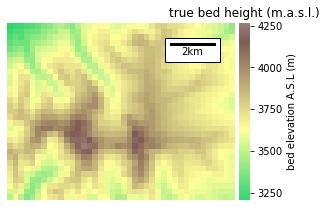

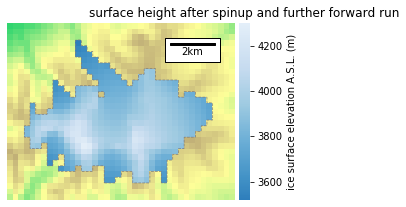

not in equilibrium! consider also plotting spinup


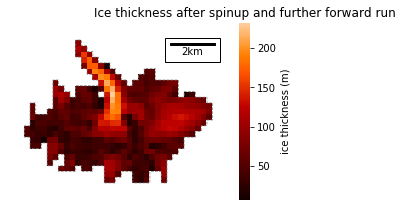

In [27]:
from combine.core.visualization import MidpointNormalize, truncate_colormap, \
    imshow_ic, plot_glacier_contours, add_colorbar, get_axes_coords

figsize = (4.5, 3)
spinup_surf = salem.GeoTiff(gdir.get_filepath('spinup_dem')).get_vardata()
reference_surf = salem.GeoTiff(gdir.get_filepath('ref_dem')).get_vardata()
bed_2d = salem.GeoTiff(gdir.get_filepath('dem')).get_vardata()

ref_ice_mask = np.load(gdir.get_filepath('ref_ice_mask'))
ref_it = np.load(gdir.get_filepath('ref_ice_thickness'))
spinup_it = np.load(gdir.get_filepath('spinup_ice_thickness'))
masked_ice_thick_end = np.ma.masked_array(ref_it,
                                          mask=np.logical_not(ref_ice_mask))
#masked_ice_thick_start = np.ma.masked_array(spinup_it,
#                                            mask=np.logical_not(ref_ice_mask))
masked_reference_surf = np.ma.masked_array(reference_surf,
                                           mask=np.logical_not(ref_ice_mask))

#plt.ioff()

cmap = plt.get_cmap('terrain')
terrain_cmap = truncate_colormap(cmap, 0.3, 0.8)
# ---------------------------------------------------------------
# plot true bed height
fig = plt.figure(figsize=figsize)
ax = fig.add_axes(get_axes_coords(case))
im_b = imshow_ic(ax, bed_2d, case, cmap=terrain_cmap, ticks='scalebar')
cbar = add_colorbar(fig, ax, im_b)
cbar.set_label('bed elevation A.S.L (m)')
#plt.title('Bed of case {:s}, dx={:d}m'.format(case.name, case.dx))
#fname = '{:s}_bed.{:s}'.format(case.name, file_extension)
#plt.tight_layout()
#plt.savefig(os.path.join(output_dir, fname))
#plt.close(fig)
plt.title('true bed height (m.a.s.l.)')
plt.show()

cmap = plt.get_cmap('Blues_r')
cut_gray_cmap = truncate_colormap(cmap, 0.3, 0.9)

fig = plt.figure(figsize=figsize)
ax = fig.add_axes(get_axes_coords(case))
im_b = imshow_ic(ax, bed_2d, case, cmap=terrain_cmap, ticks='scalebar')
#plt.title('Ice surface height, {:s}, dx={:d}m, t={:d}a'.format(
#    case.name, case.dx, y))
im_i = imshow_ic(ax, masked_reference_surf, case, cmap=cut_gray_cmap,
                 ticks='scalebar')
cbar = add_colorbar(fig, ax, im_i)
cbar.set_label('ice surface elevation A.S.L. (m)')
plot_glacier_contours(ax, ref_ice_mask, case, resolution_enhance=10) #, linestyles='solid')
#fname = '{:s}_surf_height.{:s}'.format(case.name, file_extension)
#plt.tight_layout()
#plt.savefig(os.path.join(output_dir, fname))
#plt.close(fig)
plt.title('surface height after spinup and further forward run')
plt.show()

cmap = plt.get_cmap('gist_heat')
it_cmap = truncate_colormap(cmap, 0.05, 0.9)
if not np.all(np.equal(ref_it, spinup_it)):
    print('not in equilibrium! consider also plotting spinup')
fig = plt.figure(figsize=figsize)
ax = fig.add_axes(get_axes_coords(case))
im_it = imshow_ic(ax, masked_ice_thick_end, case, cmap=it_cmap, ticks='scalebar')
cbar = add_colorbar(fig, ax, im_it)
cbar.set_label('ice thickness (m)')
#fname = '{:s}_ice_thickness.{:s}'.format(case.name, file_extension)
plot_glacier_contours(ax, ref_ice_mask, case, resolution_enhance=10)
#plt.show()
#plt.tight_layout()
#plt.savefig(os.path.join(output_dir, fname))
#plt.close(fig)
plt.title('Ice thickness after spinup and further forward run')
plt.show()

# First guess
Now we can think about our first guess. It is created by the function below with the approach described in the referenced paper (basically depending on surface gradients).

Depending on what we want to test/show, we could also add noise to the first guess afterwards, to check stability vs first guess quality.

The first guess is also stored in a file in gdir.

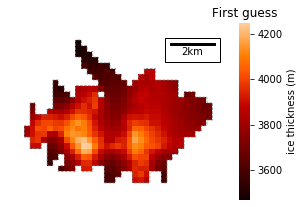

In [28]:
from combine.core.first_guess import compile_first_guess
fg_bedrock = compile_first_guess(gdir)


#plot
fg = np.ma.masked_array(fg_bedrock, mask=np.logical_not(ref_ice_mask))
cmap = plt.get_cmap('gist_heat')
it_cmap = truncate_colormap(cmap, 0.05, 0.9)
fig = plt.figure(figsize=figsize)
ax = fig.add_axes(get_axes_coords(case))
im_it = imshow_ic(ax, fg, case, cmap=it_cmap, ticks='scalebar')
cbar = add_colorbar(fig, ax, im_it)
cbar.set_label('ice thickness (m)')
#fname = '{:s}_ice_thickness.{:s}'.format(case.name, file_extension)
plot_glacier_contours(ax, ref_ice_mask, case, resolution_enhance=10)
#plt.show()
#plt.tight_layout()
#plt.savefig(os.path.join(output_dir, fname))
#plt.close(fig)
plt.title('First guess')
plt.show()

# Actual Inversion
Now we can start the actual inversion. The function below automatically collects first guess, surface after spinup as a base state to run forward from, surface after run as a target and inversion settings.

In [29]:
# maybe play around with reg_parameters? More detailed insights, whih reg_parameter stands for what in the cost_function.py code
default_Giluwe_inversion_settings['reg_parameters'] = np.array([0.2, 1.25, 1e3, 1e6, 0, 0])
gdir.write_inversion_settings(**default_Giluwe_inversion_settings)

In [30]:
from combine.core.inversion import InversionDirectory
idir = InversionDirectory(gdir)  # Use of separate InversionDirectory allows to run multiple inversions from the base of one GlacierDirectory
res = idir.run_minimize()

# note, that #function calls != #iteration


            ----------------------------------------------
            Function Call: 3
            Iteration: 1
            Cost: 237625
            Bed RMSE: 17.6944
            Bed Bias: 3.18421
            Bed Max_diff: 115.678
            Surface RMSE: 15.761
            Surface Max_diff: 116.313
            

            ----------------------------------------------
            Function Call: 4
            Iteration: 2
            Cost: 119581
            Bed RMSE: 15.6304
            Bed Bias: 1.84802
            Bed Max_diff: 122.937
            Surface RMSE: 10.9518
            Surface Max_diff: 89.1084
            

            ----------------------------------------------
            Function Call: 5
            Iteration: 3
            Cost: 81329.6
            Bed RMSE: 14.8913
            Bed Bias: 0.421507
            Bed Max_diff: 129.96
            Surface RMSE: 8.33593
            Surface Max_diff: 77.6157
            

            ---------------------------------


            ----------------------------------------------
            Function Call: 34
            Iteration: 27
            Cost: 34093.5
            Bed RMSE: 11.2418
            Bed Bias: -0.576493
            Bed Max_diff: 131.313
            Surface RMSE: 3.00667
            Surface Max_diff: 33.3582
            

            ----------------------------------------------
            Function Call: 35
            Iteration: 28
            Cost: 33769.3
            Bed RMSE: 11.0388
            Bed Bias: -0.588532
            Bed Max_diff: 131.476
            Surface RMSE: 2.81621
            Surface Max_diff: 32.1792
            

            ----------------------------------------------
            Function Call: 37
            Iteration: 29
            Cost: 33467.7
            Bed RMSE: 11.049
            Bed Bias: -0.577956
            Bed Max_diff: 131.588
            Surface RMSE: 2.77292
            Surface Max_diff: 31.8774
            

            -------------------

Have a look at the results

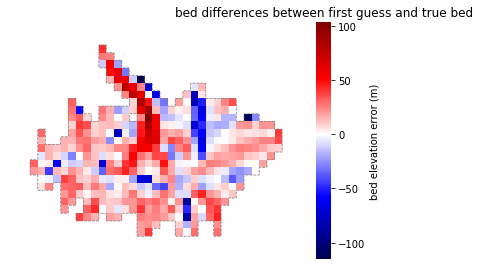

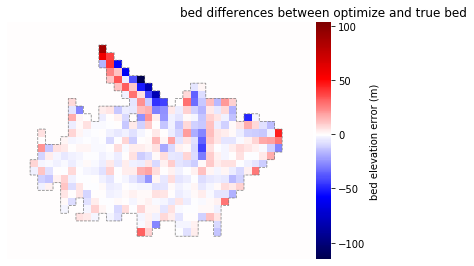

In [33]:
from combine.core.visualization import plot_bed_difference, plot_surf_difference
from combine.core.data_logging import load_pickle

path = os.path.join(gdir.dir, default_Giluwe_inversion_settings['inversion_subdir'], 'data_logger.pkl')
# Data is stored here, basically all data from each iteration step is stored in there
dl = load_pickle(path)

diff_first_guess = dl.first_guessed_bed - dl.true_bed
diff_optimized = dl.beds[-1] - dl.true_bed
cbar_min = min(diff_first_guess.min(), diff_optimized.min())
cbar_max = max(diff_first_guess.max(), diff_optimized.max())
cbar_min_max = max(abs(cbar_min), abs(cbar_max))
norm = MidpointNormalize(midpoint=0., vmin=-cbar_min_max,
                         vmax=cbar_min_max)
my_cmap = plt.get_cmap('seismic')

fig = plt.figure()
plot_bed_difference(diff_first_guess, None, case,
                    ice_mask=ref_ice_mask,
                    bed_measurements=None,
                    cbar_min=cbar_min, cbar_max=cbar_max,
                    show_cbar=True, norm=norm, cmap=my_cmap,
                    figsize=figsize, existing_fig=fig)
plt.title('bed differences between first guess and true bed')

fig = plt.figure()
plot_bed_difference(diff_optimized, None, case,
                    ice_mask=ref_ice_mask,
                    bed_measurements=None,
                    cbar_min=cbar_min, cbar_max=cbar_max,
                    show_cbar=True, norm=norm, cmap=my_cmap,
                    figsize=figsize, existing_fig=fig)
plt.title('bed differences between optimize and true bed')
plt.show()

The same for the surfaces

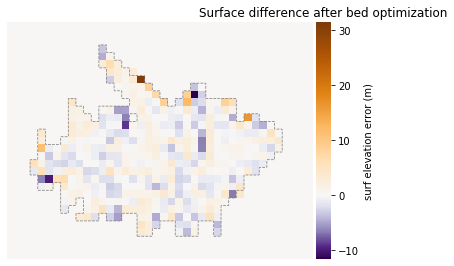

In [34]:
diff_optimized_surf = dl.surfs[-1] - dl.ref_surf
cbar_min = diff_optimized_surf.min()
cbar_max = diff_optimized_surf.max()
my_cmap = plt.get_cmap('PuOr_r')

fig = plt.figure()
plot_surf_difference(diff_optimized_surf, None, case,
                     ice_mask=ref_ice_mask, cbar_min=cbar_min,
                     cbar_max=cbar_max, show_cbar=True,
                     norm=norm, cmap=my_cmap, figsize=figsize, existing_fig=fig)
plt.title('Surface difference after bed optimization')
plt.show()